In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from pathlib import Path
from config import *
from load_utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae1D'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:third_wheel_system_conv_ae1D_sl_16
num selection:1 - exp name:third_wheel_system_conv_ae1D_sl_40
num selection:2 - exp name:4_wheels_system_conv_ae1D_sl_40_run_2
num selection:3 - exp name:4_wheels_system_conv_ae1D_sl_16
num selection:4 - exp name:4_wheels_system_conv_ae1D_sl_40_flattened_increasing_less_par


In [16]:
select_exp = '2'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheels_system_conv_ae1D_sl_40_run_2


In [17]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/conv_ae1D/4_wheels_system_conv_ae1D_sl_40_run_2/summary.csv


In [18]:
summary.drop(columns = ['train_loss']).reset_index().head()

,index,Unnamed: 0,name,parameters_number,val_loss
0,49,1,"trainCONVAE1D_da743_00033_33_activation=Elu,ba...",101540,0.000104
1,48,30,"trainCONVAE1D_da743_00040_40_activation=Elu,ba...",40195,0.000333
2,47,24,"trainCONVAE1D_da743_00013_13_activation=Elu,ba...",40736,0.001260
3,46,4,"trainCONVAE1D_da743_00008_8_activation=Elu,bat...",119780,0.001410
4,45,27,"trainCONVAE1D_da743_00007_7_activation=Elu,bat...",40736,0.002245


In [19]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 120, 'flattened': 0, 'increasing': 0, 'kernel_size': 9, 'latent_dim': 512, 'lr': 0.0009, 'lr_patience': 5, 'n_layers': 1, 'pool': 0, 'seq_in_length': 40}


In [20]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

# code above replaced with the following 
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:2" if use_cuda else "cpu")

In [21]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)

params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [22]:
for key, value in cfg.items():
    if getattr(value, 'items', None) is None:
        print(key, value)
    else:
        print(key)
        for _key, _value in value.items():
            print('\t', _key, _value)

tune_config
	 epochs tune.choice([200])
	 lr tune.choice([0.0009, 0.0003, 0.001])
	 batch_size tune.choice([100, 500])
	 seq_in_length tune.choice([40])
	 dilation tune.choice([1])
	 filter_num tune.choice([12, 24, 36, 42, 64, 100, 110, 120])
	 n_layers tune.choice([1, 2])
	 lr_patience tune.choice([5, 10])
	 kernel_size tune.choice([3, 5, 7, 9, 11])
	 increasing tune.choice([0])
	 flattened tune.choice([0])
	 latent_dim tune.choice([100, 160, 320, 256, 400, 512])
	 pool tune.choice([1, 0])
	 activation tune.choice(['Elu', 'Relu'])
dataset
	 name sentinel
	 sequential False
	 sample_rate 4s
	 scaled True
	 clean True
	 shuffle False
	 feats all
	 columns ['RW1_motcurr', 'RW2_motcurr', 'RW3_motcurr', 'RW4_motcurr', 'RW1_therm', 'RW2_therm', 'RW3_therm', 'RW4_therm', 'RW1_speed', 'RW2_speed', 'RW3_speed', 'RW4_speed', 'RW1_cmd_volt', 'RW2_cmd_volt', 'RW3_cmd_volt', 'RW4_cmd_volt']
	 dataset_subset 1000000
	 columns_subset 0
	 target None
	 predict False
	 forecast_all False
	 train_val_s

In [23]:
if 'flattened' in params_conf.keys():
    flattened = flattened = params_conf['flattened']
else:
    flattened=False
if 'increasing' in params_conf.keys():
    increasing = flattened = params_conf['increasing']
else:
    increasing=False
    
model = CONV_AE1D(in_channel=params_conf['in_channel'],  length=params_conf['length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                  latent_dim = params_conf['latent_dim'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened, increasing=increasing).to(device).float()

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 120, kernel_size=(9,), stride=(2,), padding=(4,))
        (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(120, 60, kernel_size=(9,), stride=(2,), padding=(4,))
        (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(60, 120, kernel_size=(2,), stride=(2,))
        (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (dec_lay_1): Sequential(
 

In [24]:
columns_subset=params_conf['columns_subset']
dataset_subset=params_conf['dataset_subset']
cols = cfg.dataset.columns
scaled = cfg.dataset.scaled
train_val_split = cfg.dataset.train_val_split
target = params_conf['target']
sequence_length = params_conf['sequence_length']
out_window = params_conf['sequence_length']
predict = params_conf['predict']

dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")

In [29]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])


dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=1000, transform=transform)

In [26]:
len(test_iter)

15905

In [14]:
compute_mse_val_loss=True

In [30]:
mse_val_loss_list = []
criterion = nn.MSELoss()
if compute_mse_val_loss:
    for i, (x,y) in enumerate(test_iter):
        yo = model(x)
        mse_val_loss_list.append(criterion(yo, x).item())
        print(i, np.mean(mse_val_loss_list))
    mse_val_loss = np.mean(mse_val_loss_list)
    print(mse_val_loss)

0 0.00013796534040011466
1 0.00015702204109402373
2 0.0001682773775731524
3 0.0001919453643495217
4 0.0001951174985151738
5 0.00018817808692498753
6 0.00017788063892762044
7 0.00016932025755522773
8 0.00016125511724062057
9 0.00015615511438227259
10 0.00015334694564279
11 0.00015191697275440674
12 0.00015627862516199597
13 0.00016494494203860604
14 0.00017013769781139368
15 0.00017278580207857885
16 0.00017791383202968384
17 0.00017658193286883438
18 0.00017411936661167266
19 0.0001887954986159457
20 0.0001858951419264832
21 0.00018465676012882878
22 0.00018591315545010096
23 0.00018648896821105154
24 0.00018458045175066219
25 0.00018248642439945028
26 0.0001803913983167149
27 0.0001765036504366435
28 0.00017354639391575395
29 0.00017022304358154844
30 0.0001670855776718517
31 0.00016459043763461523
32 0.00016231944887708366
33 0.0001597757128526128
34 0.000158239525418529
35 0.00015638243854078205
36 0.0001555493349646772
37 0.00015495176672917105
38 0.00015310004173676507


KeyboardInterrupt: 

In [18]:
num_batch=5
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'], arch=architecture)

time horizon 200


In [19]:
yo = model(x.to(device))

In [20]:
seq_len = sequence_length
par_nums = count_parameters(model)

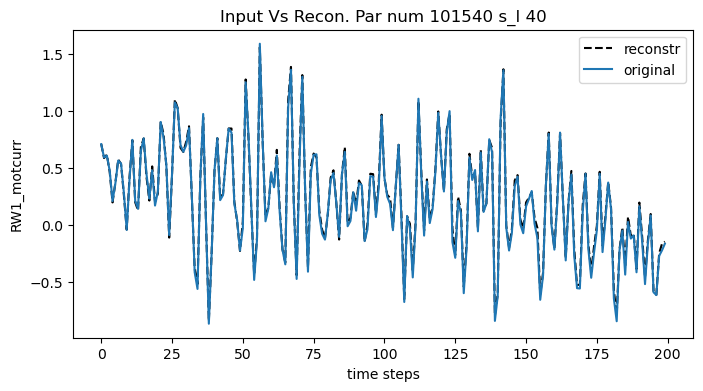

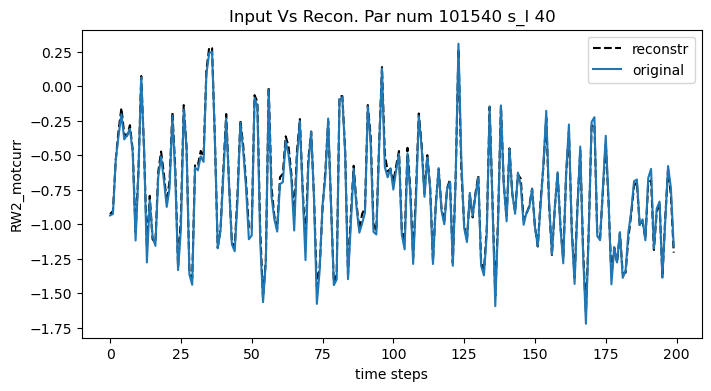

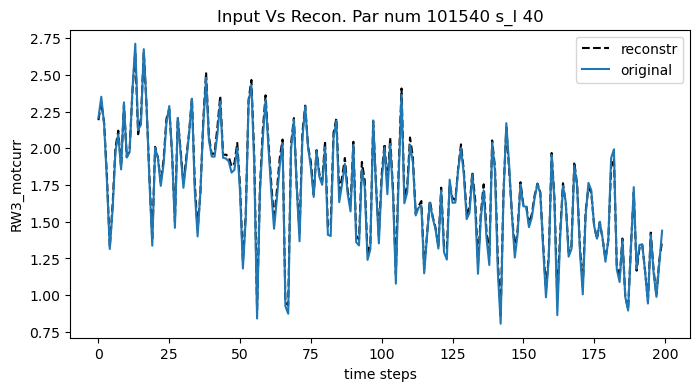

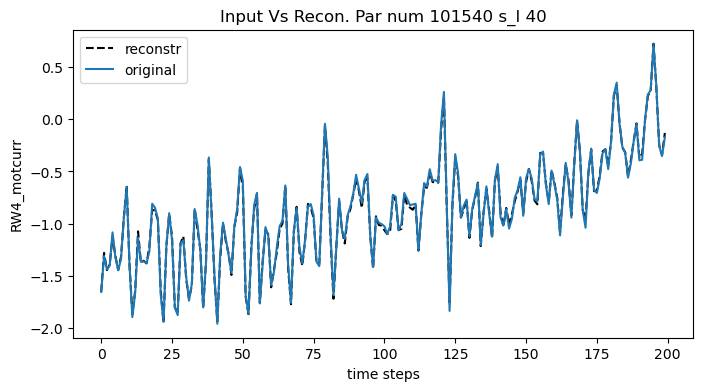

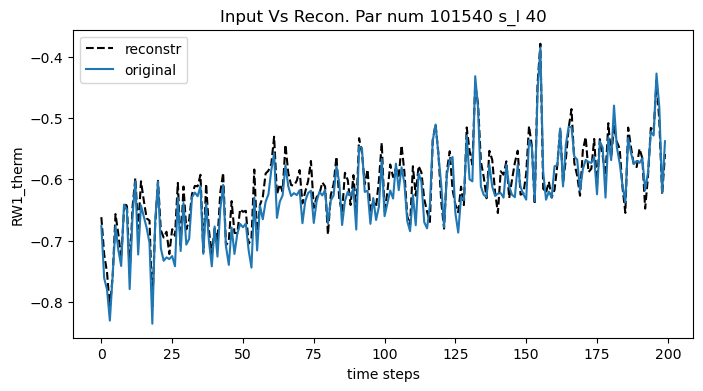

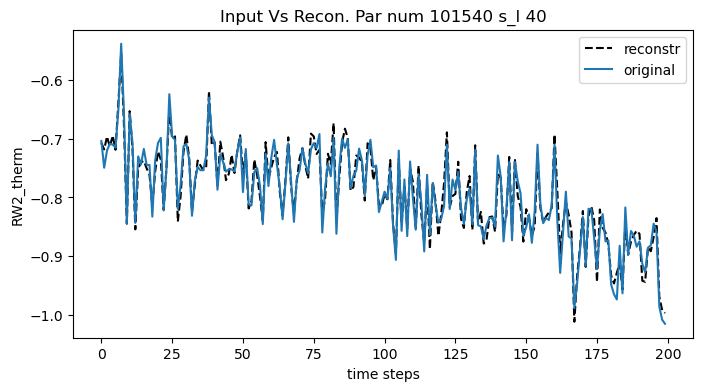

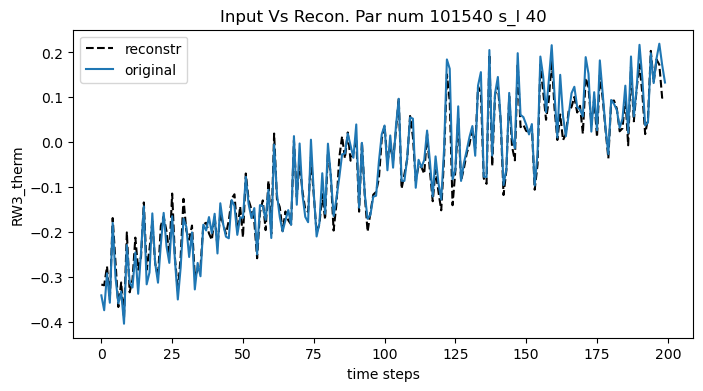

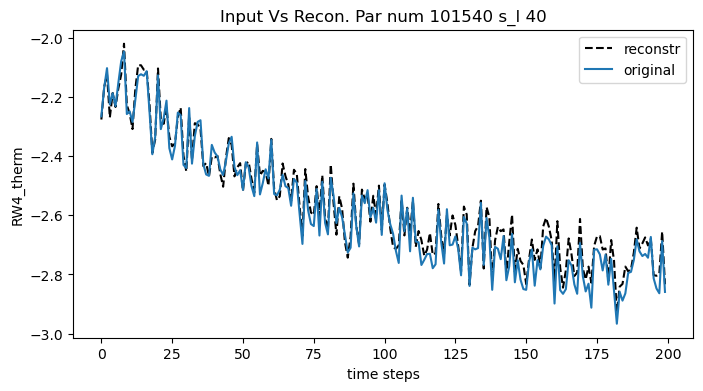

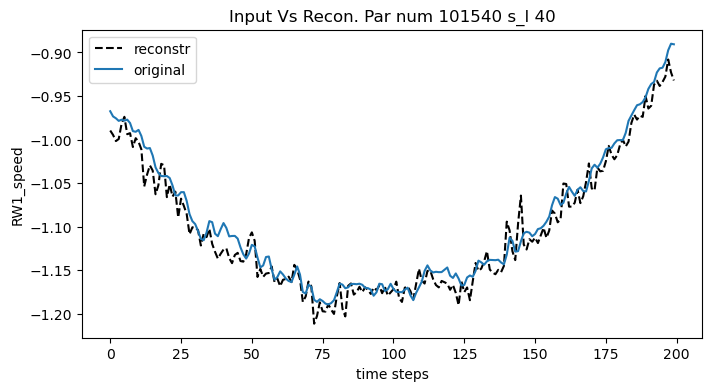

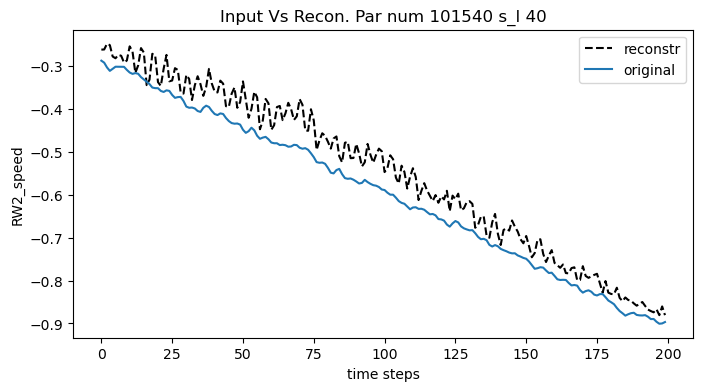

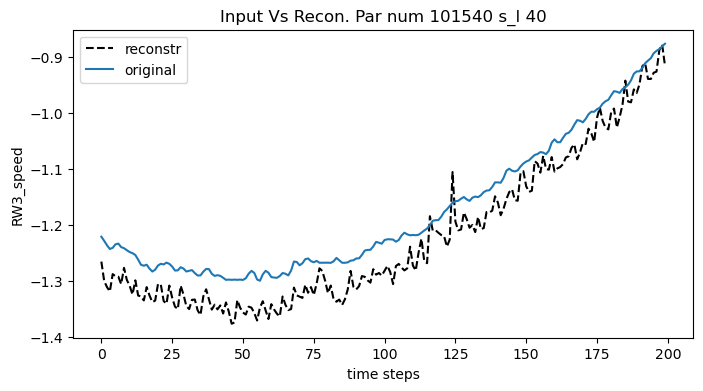

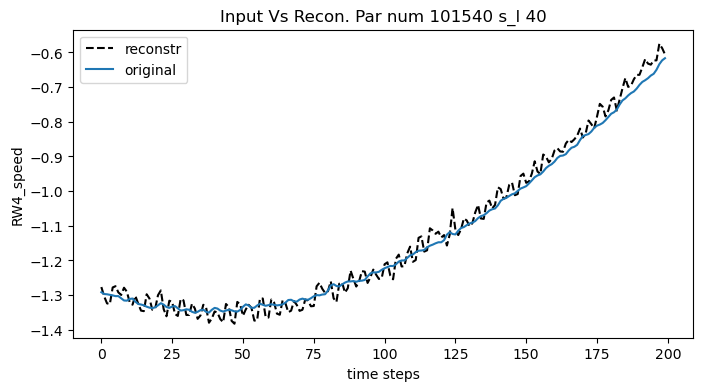

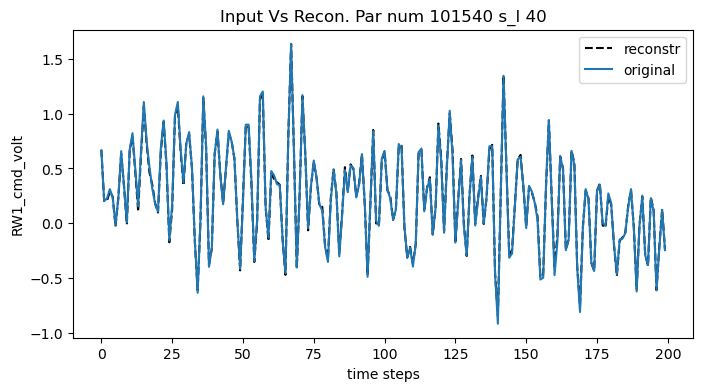

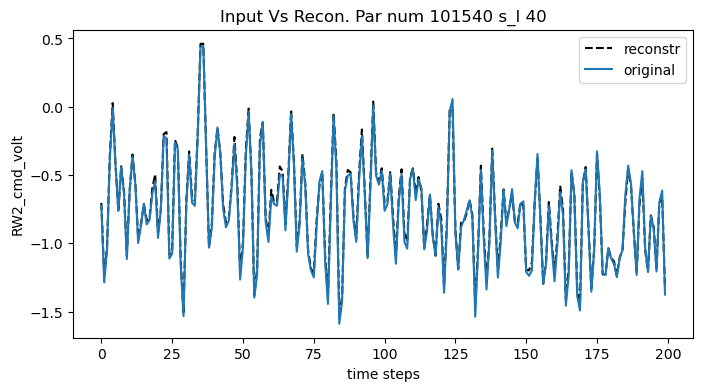

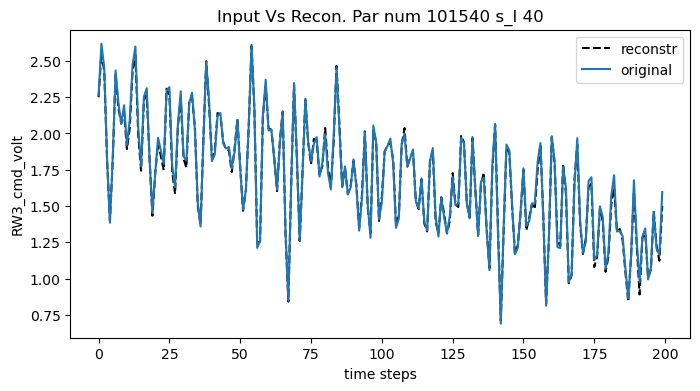

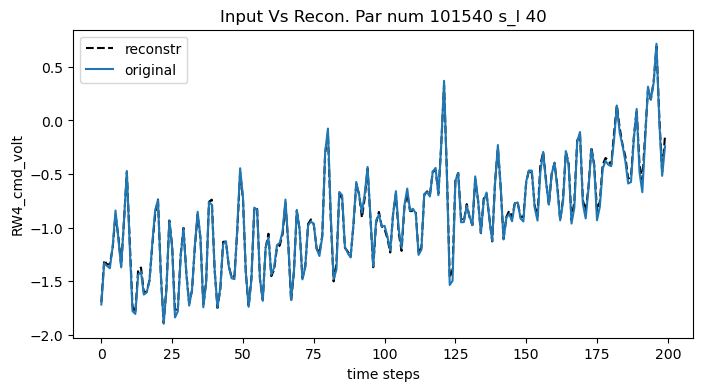

In [21]:
show_results(x, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)